In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [3]:
# import zipfile
# corpus_zip = zipfile.ZipFile('/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.zip', 'r')
# recipe_str = corpus_zip.read(corpus_zip.namelist()[0])
# recipe = json.loads(recipe_str)

In [4]:
filepath = "/Users/mvellera/USF/Intersession/Practicum (Target)/Data/recipe1M_layers/layer1.json"
op_file_path = "data/ing_density.csv"
with open(filepath) as json_data:
    recipe = json.load(json_data)

In [5]:
unit_abbreviation = { 'tbsp' : ["tablespoon"],
                      'tsp' : ['teaspoon'],
                     'ml' : ['milliliter'],
                     'cup' : ['cups','cup'],
                     'oz' : ['ounces','oz', 'ounce']
    
}

In [6]:
# # loading recipe
# dict_ingredients= recipe_load(n=2, recipe=recipe)
# df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
# df_combined_ing

In [7]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [8]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
k=3

In [9]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, product_ids=group10['tcin'], max_rank=3)
with open('data/hier_embeddings3.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                                cross_rank=k,
                                bi_rank=30)

pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [22]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
print(i)
dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(float)


qty = Qty_normal_map(unit_abbreviation = unit_abbreviation, op_file_path= op_file_path)
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = df_combined_ing.groupby(by=['ingredient', 'normalized_unit'], 
                                               as_index = False)\
                                      .agg({'quantity': 'sum', 'Volume_in_ml': 'sum'})
#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


320489
Recipe: BBQ Salmon Salad


/Users/mvellera/USF/Intersession/Practicum (Target)/Code/qty_mapping.py:54: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [23]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,KRAFT 2% Milk Shredded Cheddar Cheese,cup,0.50,112.50,"(1.0, 28.0, oz)",1.0,28.0,oz
1,KRAFT Classic Ranch Dressing,cup,0.50,112.50,"(1.0, 16.0, tbsp)",1.0,16.0,tbsp
2,KRAFT Original Barbecue Sauce,cup,0.25,56.25,"(1.0, 283.0, cup)",1.0,283.0,cup
3,black beans,can,1.00,0.00,"(1.0, 257.0, cup (8 fl oz))",1.0,257.0,cup (8 fl oz)
4,ears corn on the cob,count,2.00,0.00,"(1.0, 125.0, ear yields)",1.0,125.0,ear yields
5,green onions,count,4.00,0.00,"(1.0, 100.0, cup)",1.0,100.0,cup
6,pkg torn mixed salad greens,count,1.00,0.00,"(1.0, 35.0, cup)",1.0,35.0,cup
7,red pepper strips,cup,0.50,112.50,"(1.0, 155.0, cup)",1.0,155.0,cup
8,skinless salmon fillets,count,4.00,0.00,"(1.0, 85.0, fillet)",1.0,85.0,fillet


In [24]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients, 3)

rslt_df = group10[['title', 'tcin', 'short_desc','price','net_content_quantity_unit_of_measure', 'net_content_quantity_value', 'package_weight_unit_of_measure','package_weight']]
final_rslt_df=pd.DataFrame()

for i in range(len(ranked_match)):
    rslt_inter = rslt_df.loc[group10['tcin'].isin(ranked_match[i])] 
    ing = recipe_ingredients[i]
    length = min(len(ranked_match[i]),9)
    for n in range(0,length):
        for j, row in rslt_inter.iterrows():
            if row.tcin == ranked_match[i][n] :
                rslt_inter.loc[j,'rank']=n+1
                rslt_inter.loc[j,'ingredient']=ing
                break
       
    rslt_inter_n=rslt_inter.sort_values('rank')[0:9] 
    final_rslt_df= pd.concat([final_rslt_df,rslt_inter_n], ignore_index=True)

#matching target database with recipe 
join_df = pd.merge(final_rslt_df, final_df, 
                   how = 'left', on = 'ingredient')

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price'])
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']]

/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


kosher salt
[13170448, 49089779, 47088548]


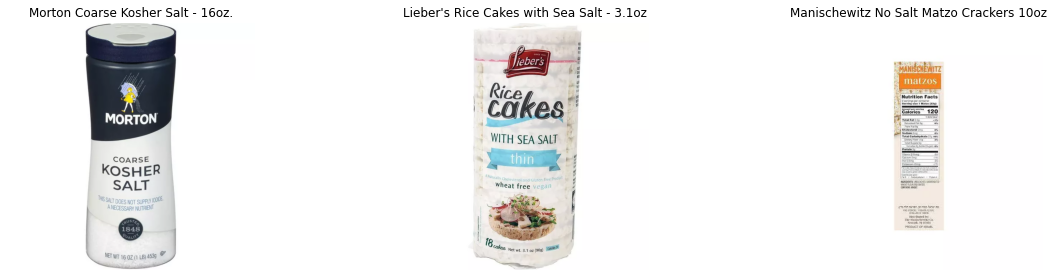

In [33]:
dp.display_products_ingredient('kosher salt')

black beans
[47087603 47088065 47088090]


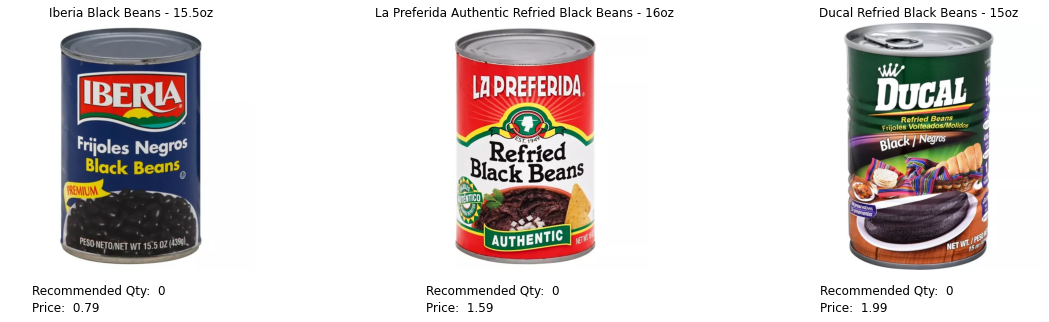

ears corn on the cob
[79580985 79653738 79653736]


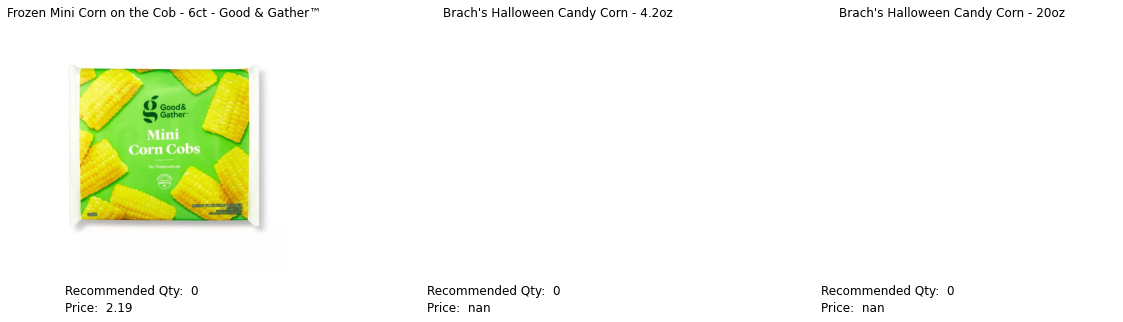

green onions
[14919617 16250486 78873596]


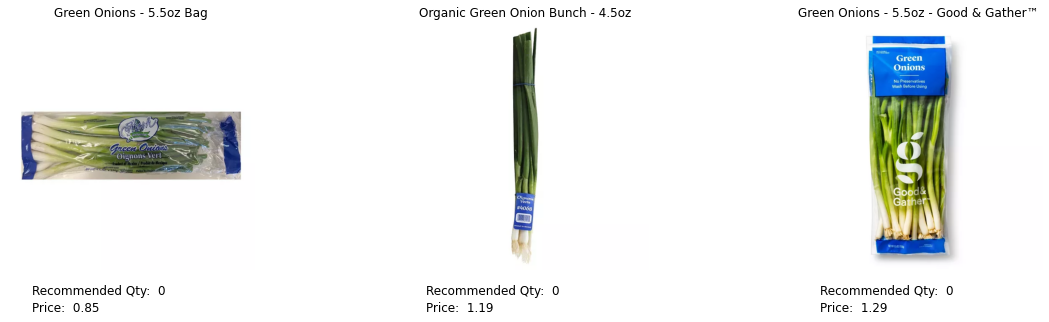

kraft classic ranch dressing
[12946470 52165796 14907440]


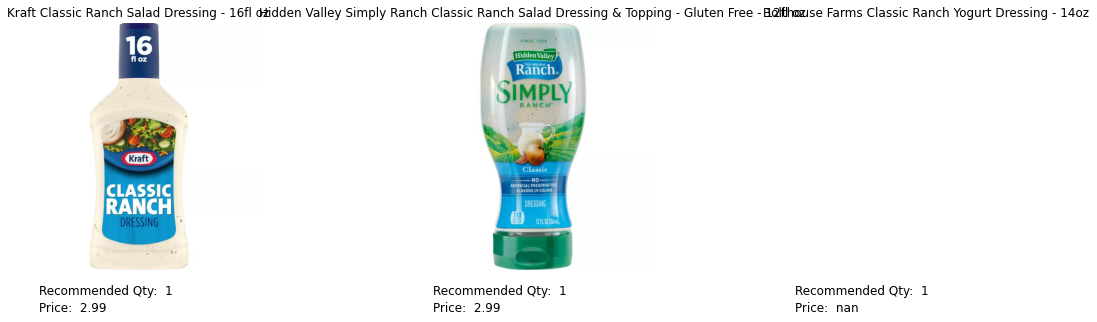

kraft milk shredded cheddar cheese
[14909504 14909477 53408911]


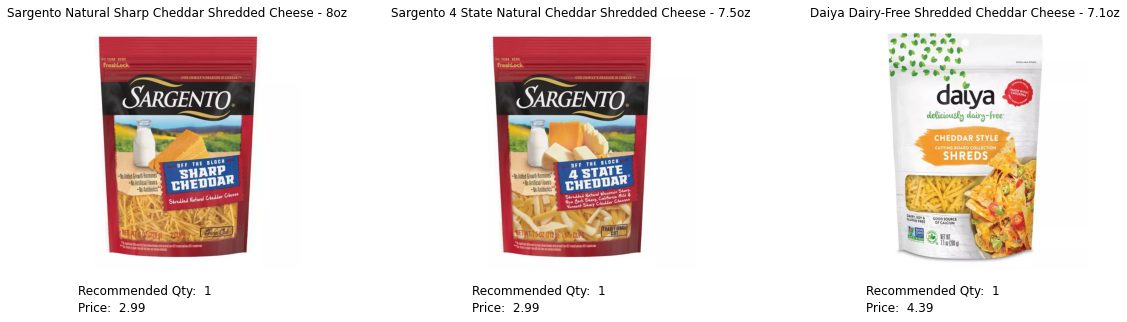

kraft original barbecue sauce
[13022823 12946076 53624859]


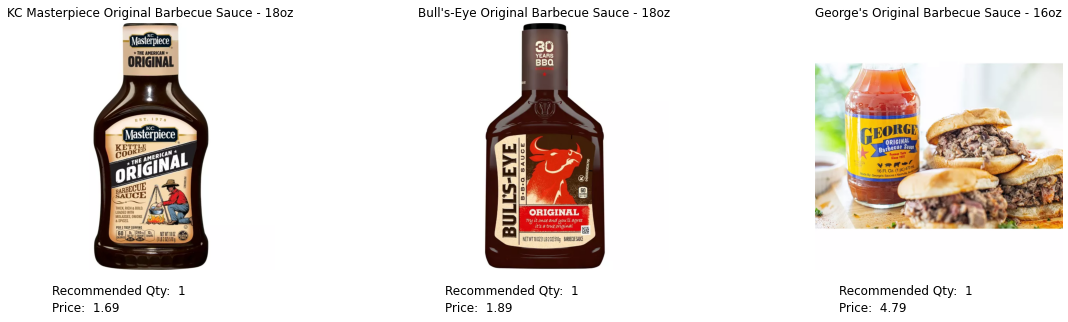

pkg torn mixed salad greens
[79757763 79757764 50494879]


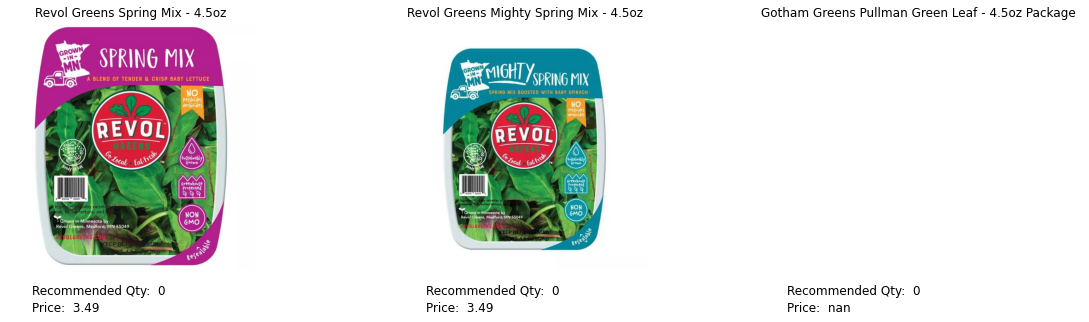

red pepper strips
[16617635 79286419 77584991]


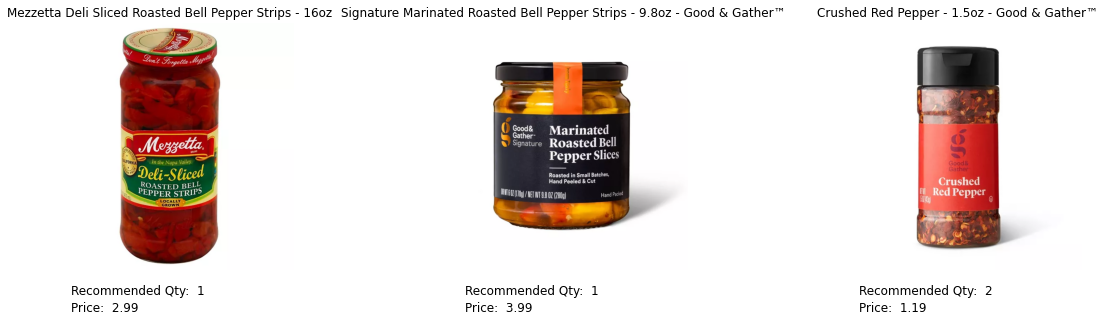

skinless salmon fillets
[79313415 14673082 14673133]


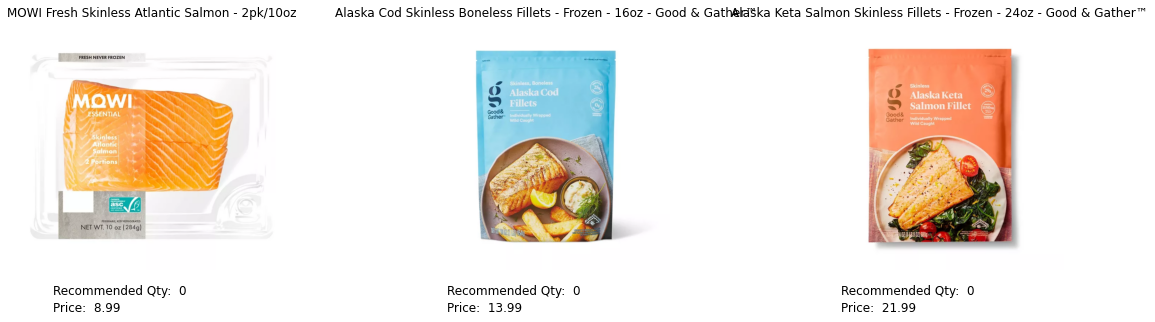

In [28]:
dp.display_products_df(display_df, 3)